dataset : https://www.kaggle.com/c/street-view-getting-started-with-julia

In [185]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from skimage import io
from skimage import color
from skimage import feature
from skimage import transform

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

%matplotlib inline

In [186]:
#labels csv
labels_ = [] # first line is dirty
with open('./trainLabels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels_.append(row[1])


In [187]:
#loading the dataset
images = []
labels = []
SAMPLE_DIR = './trainResized'
for i, label in enumerate(labels_):
    if i == 0 : continue
    labels.append(label)
    im = io.imread('{}/{}.Bmp'.format(SAMPLE_DIR, i))
    gray = color.rgb2gray(im)
    ############edges = feature.canny(gray)
    images.append(gray)

images = np.array(images)
labels = np.array(labels)

print (images.shape, labels.shape)

(6283, 20, 20) (6283,)


# This is the original after some initial transforms

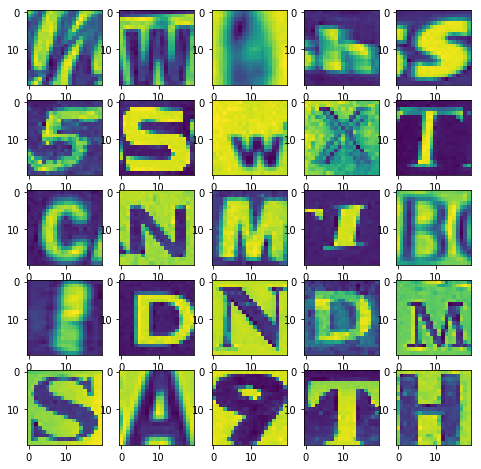

In [188]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images[random.randint(0, len(images)-1)])

# In these 2 steps we are normalizing the set to have equal number of samples for all cathegory -- also generating new smaples

In [189]:
# filtering the set
# this is optional!
letters = ['A', 'B', 'C', 'D', 'E','X', 'Y', '1', '2','3', '4', '5']

mask = (labels == letters[0])
for i in range(len(letters)-1):
    mask = mask | (labels == letters[i+1])

images = images[mask]
labels = labels[mask]
print (images.shape, labels.shape)

#label stats
def label_stats(labels, letters):
    stats = {}
    for letter in letters:
        stats[letter] = len(labels[labels == letter])
    return stats

print (label_stats(labels, letters))

(1576, 20, 20) (1576,)
{'D': 165, 'A': 459, 'E': 357, 'C': 170, '5': 41, '1': 65, 'B': 90, '2': 59, '3': 36, '4': 37, 'X': 43, 'Y': 54}


In [190]:
# generates more images the way that every sample has equal number
def generate_and_eq_more_images(images, labels, letters):
    
    im_list = images.tolist()
    labels_list = labels.tolist()
    
    stats = label_stats(labels, letters)
    max_sample_size = max(stats.values()) # the maximus sample size
    print ("Max: ", max_sample_size )
    for letter in letters:
        samples_to_gen = max_sample_size - stats[letter] # number of new samples to be generated
        sample_images = images[labels == letter] # original image sample, this is the source for the generated images
        print("label ", letter, samples_to_gen)
        for i in range(samples_to_gen): #adding generated images N times
            random_im = sample_images[random.randint(0,len(sample_images)-1)]
            im_list.append(gen_transform(random_im))
            labels_list.append(letter)
            
    return np.array(im_list), np.array(labels_list)
    
def gen_transform(im):
    new_im = transform.rotate(im, random.randint(-20, 20))
    return new_im
    
    
    
images, labels = generate_and_eq_more_images(images, labels, letters)

print (images.shape, labels.shape)
print (label_stats(labels, letters))

Max:  459
label  A 0
label  B 369
label  C 289
label  D 294
label  E 102
label  X 416
label  Y 405
label  1 394
label  2 400
label  3 423
label  4 422
label  5 418
(5508, 20, 20) (5508,)
{'D': 459, 'A': 459, 'E': 459, 'C': 459, '5': 459, '1': 459, 'B': 459, '2': 459, '3': 459, '4': 459, 'X': 459, 'Y': 459}


In [191]:
## the canny transform
im_list = []
for i in range(len(images)):
    im_list.append(feature.canny(images[i]))
images = np.array(im_list)

E


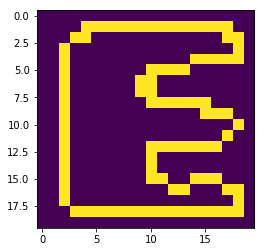

In [192]:
N = 111
print(labels[N])
i = images[N]

plt.imshow(i)



# This is what the machine sees -- after canny transform

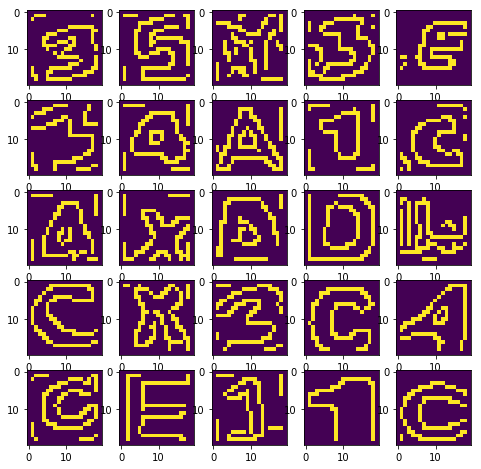

In [193]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images[random.randint(0, len(images)-1)])

# The Random forest way

In [194]:
data_x = images.reshape(images.shape[0], -1)
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, labels, test_size=0.33, random_state=44)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(3690, 400) (1818, 400) (3690,) (1818,)


In [195]:
#clf = svm.SVC()
clf = ensemble.RandomForestClassifier()

clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.99728997289972898

In [196]:
pred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print (score)

0.716171617162


[[ 80   3   5   5   7   1   1  15  12  16  11   6]
 [  6  80   2   5   8   1   6   3  10   9   9  13]
 [  3   3 105   6   6   2   2  13   6   6   3   1]
 [  6   3   9  95   0   0   4  10   4   2   3   1]
 [  7  10   1   4  79   2   4   5  13   8   7  12]
 [  1   2   7   3   3 122   7  13   5   0   4   0]
 [  3   2   4   0   0   7 108   6   1   0   1   1]
 [  6   0   5   1   0   4   4 117   5   2   3   0]
 [  1   3   1   2   1   4   1  11 113   2   2   5]
 [  0   2   0   2   2   0   1   3   4 137   0   1]
 [  4   1   0   0   0   0   0   6   8   3 129   0]
 [  1   1   1   2   3   0   0   4   5   6   3 137]]


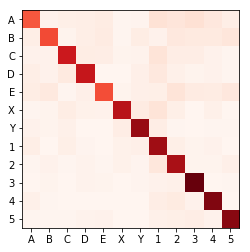

In [197]:
cm = metrics.confusion_matrix(y_test, pred, labels=letters)
print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)

# The neural network way


In [198]:
# binarizing the labels
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
data_y = lb.transform(labels)
data_x = images.reshape(images.shape[0], images.shape[1], images.shape[2], -1)

In [199]:
xx_train, xx_test, yy_train, yy_test = model_selection.train_test_split(data_x, data_y, test_size=0.33, random_state=44)
print (xx_train.shape, xx_test.shape, yy_train.shape, yy_test.shape)

(3690, 20, 20, 1) (1818, 20, 20, 1) (3690, 12) (1818, 12)


In [242]:
model = Sequential()
B = 2

model.add(Convolution2D(16, B, B, input_shape = (xx_train.shape[1], xx_train.shape[2], 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print (model.output)

model.add(Convolution2D(32, B, B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print (model.output)

model.add(Flatten())
print (model.output)

model.add(Dense(4 * 4 * 32))
print (model.output)

model.add(Dense(256))
print (model.output)

model.add(Dense(128))
print (model.output)

model.add(Dense(64))
print (model.output)

model.add(Dense(32))
print (model.output)

model.add(Dense(yy_train.shape[1]))
print (model.output)


Tensor("Relu_57:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("Relu_58:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("Reshape_139:0", shape=(?, ?), dtype=float32)
Tensor("add_496:0", shape=(?, 512), dtype=float32)
Tensor("add_497:0", shape=(?, 256), dtype=float32)
Tensor("add_498:0", shape=(?, 128), dtype=float32)
Tensor("add_499:0", shape=(?, 64), dtype=float32)
Tensor("add_500:0", shape=(?, 32), dtype=float32)
Tensor("add_501:0", shape=(?, 12), dtype=float32)


In [243]:
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [250]:
E = 20
history = model.fit(xx_train, yy_train, nb_epoch=E)

Epoch 1/20
3690/3690 [==============================] - 2s - loss: 0.0299 - acc: 0.9070     - ETA: 0s - loss: 0.0297 - 
Epoch 2/20
3690/3690 [==============================] - 2s - loss: 0.0298 - acc: 0.9098     
Epoch 3/20
3690/3690 [==============================] - 2s - loss: 0.0298 - acc: 0.9138     - ETA: 0s
Epoch 4/20
3690/3690 [==============================] - 2s - loss: 0.0295 - acc: 0.9095     - ETA: 0s - loss: 0.0295 - acc: 0.9
Epoch 5/20
3690/3690 [==============================] - 2s - loss: 0.0299 - acc: 0.9108     
Epoch 6/20
3690/3690 [==============================] - 2s - loss: 0.0296 - acc: 0.9038     
Epoch 7/20
3690/3690 [==============================] - 1s - loss: 0.0295 - acc: 0.9122     
Epoch 8/20
3690/3690 [==============================] - 2s - loss: 0.0296 - acc: 0.9130     
Epoch 9/20
3690/3690 [==============================] - 2s - loss: 0.0296 - acc: 0.9149     
Epoch 10/20
3690/3690 [==============================] - 2s - loss: 0.0292 - acc: 0.9173    

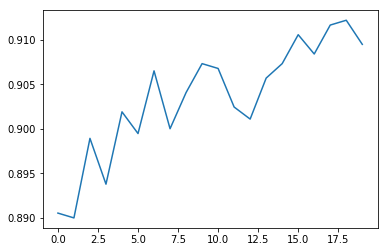

In [248]:
plt.plot(history.history['acc'])

0.90099009901
[[127   7   1   2   0   2   1   3   4   0   0   0]
 [  4 130   1   0   1   1   2   5   1   1   0   0]
 [  0   0 151   0   0   0   0   0   0   0   0   1]
 [  0   3   0 141   0   4   0   0   0   0   1   2]
 [  8   0   3   0 145   0   1   3   0   3   0   0]
 [  7   2   0   4   3 140   4   0   0   0   1   1]
 [  0   1   1   0   6   1 127   7   0   7   1   1]
 [  2   1   0   1   0   0   3 146   1   2   0   0]
 [  3   1   0   2   0   1   1   2 125   0   0   2]
 [  0   3   0   1   3   0  10   5   1 128   0   1]
 [  1   3   0   1   1   0   0   0   0   0 156   5]
 [  1   0   0   0   0   0   4   0   4   0   2 122]]


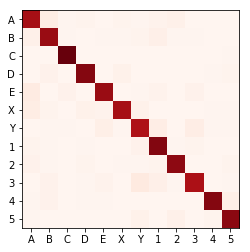

In [249]:
pred = np.argmax(model.predict(xx_test), axis=1)
truth = np.argmax(yy_test, axis=1)

print(metrics.accuracy_score(truth, pred))

cm = metrics.confusion_matrix(truth, pred)
print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)
